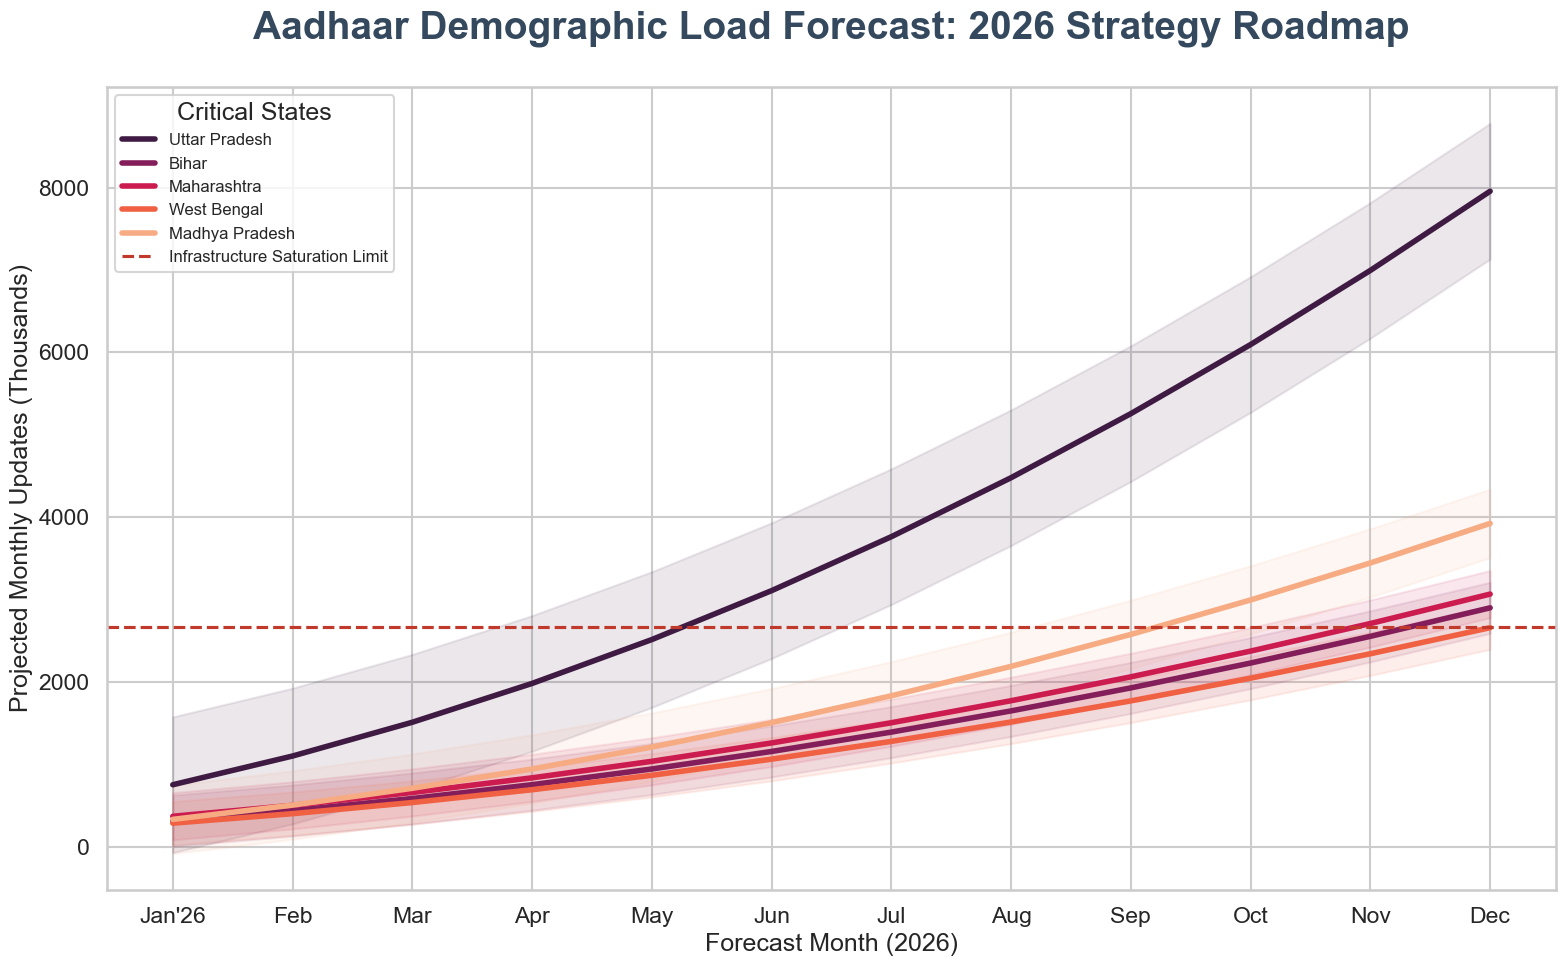

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
df = pd.read_csv("E:\\DATA ANALYTICS\\UIDAI-Data-Hackathon-2026-main\\Demographic\\demographic_processed.csv")
df['date'] = pd.to_datetime(df['date'])
df['total_demo'] = df['demo_age_5_17'] + df['demo_age_17_']
df['month_idx'] = (df['date'].dt.year - 2025) * 12 + df['date'].dt.month
state_monthly = df.groupby(['state', 'month_idx'])['total_demo'].sum().reset_index()
top_states = state_monthly.groupby('state')['total_demo'].sum().nlargest(5).index.tolist()
future_months_idx = np.arange(13, 25)
month_names_2026 = ["Jan'26", "Feb", "Mar", "Apr", "May", "Jun", 
                    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

plt.figure(figsize=(16, 10))
sns.set_theme(style="whitegrid", context="talk")
colors = sns.color_palette("rocket", len(top_states))

for i, state in enumerate(top_states):
    state_df = state_monthly[state_monthly['state'] == state].sort_values('month_idx')
    X, y = state_df[['month_idx']].values, state_df['total_demo'].values
    poly = PolynomialFeatures(degree=2)
    model = LinearRegression().fit(poly.fit_transform(X), y)
    y_pred = model.predict(poly.transform(future_months_idx.reshape(-1, 1)))
    rmse = np.sqrt(np.mean((y - model.predict(poly.fit_transform(X)))**2))
    plt.plot(future_months_idx, y_pred/1e3, label=state, color=colors[i], linewidth=4)
    plt.fill_between(future_months_idx, (y_pred - 1.96*rmse)/1e3, (y_pred + 1.96*rmse)/1e3, 
                     color=colors[i], alpha=0.1)
plt.title("Aadhaar Demographic Load Forecast: 2026 Strategy Roadmap", 
          fontsize=28, fontweight='bold', pad=35, color='#34495E')
plt.xlabel("Forecast Month (2026)", fontsize=18)
plt.ylabel("Projected Monthly Updates (Thousands)", fontsize=18)
plt.xticks(future_months_idx, month_names_2026)
peak_2025 = state_monthly['total_demo'].max() / 1e3
plt.axhline(y=peak_2025 * 1.15, color='#C0392B', linestyle='--', label='Infrastructure Saturation Limit')
plt.legend(title="Critical States", loc='upper left', fontsize=12)
plt.tight_layout()
plt.savefig('demographic_2026_strategy_forecast.png', dpi=300)

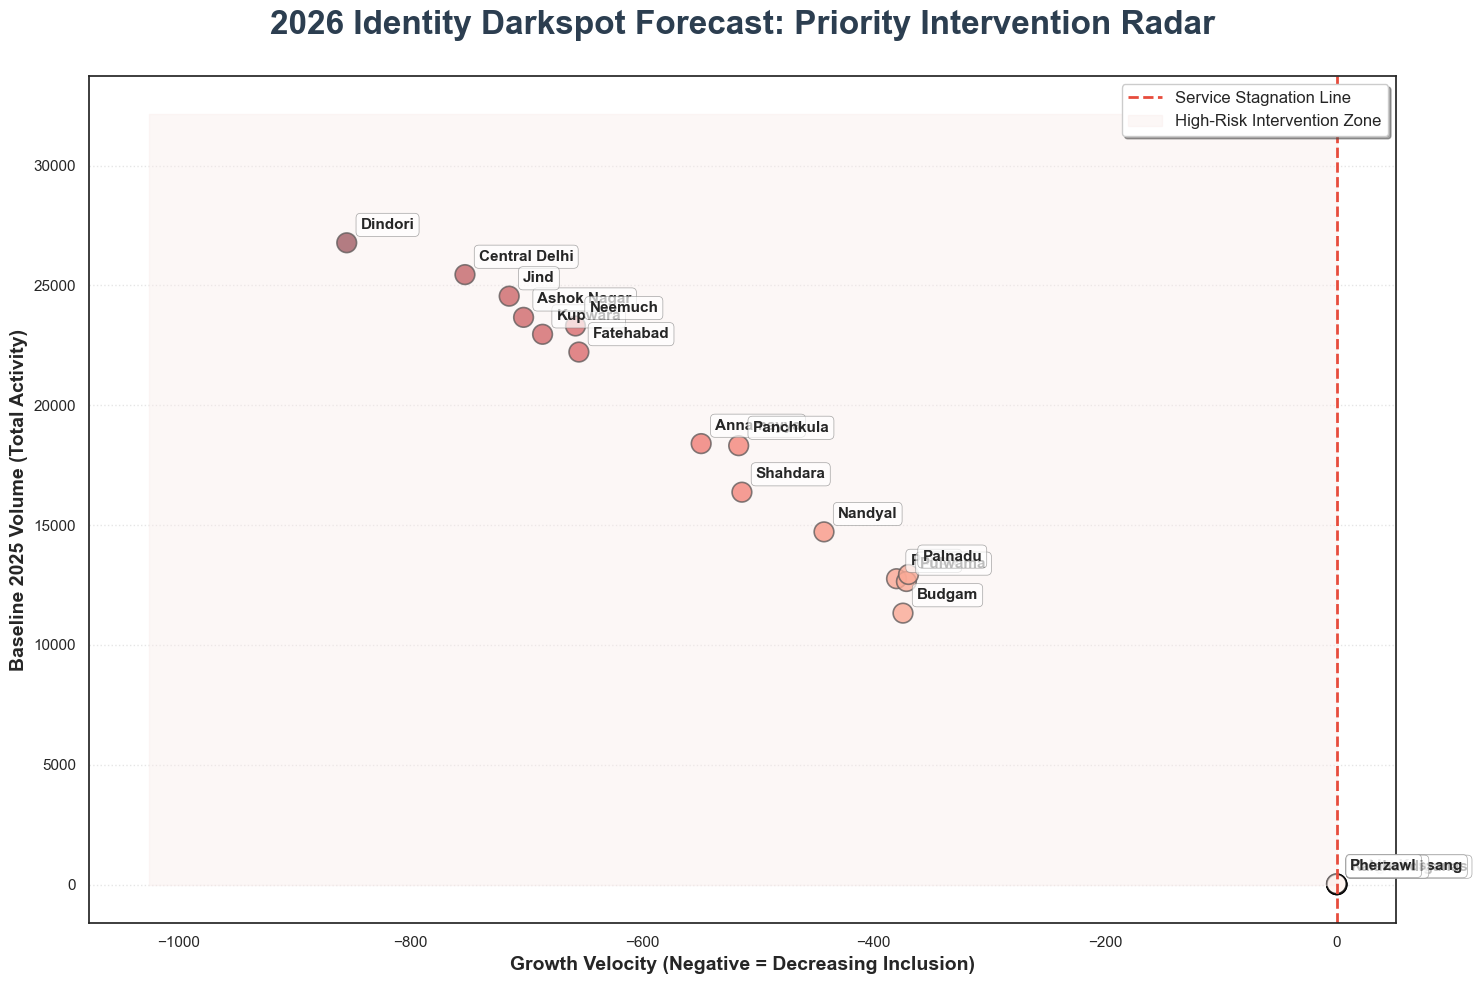

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# 1. LOAD DATA
df = pd.read_csv("E:\\DATA ANALYTICS\\UIDAI-Data-Hackathon-2026-main\\Demographic\\demographic_processed.csv")
df['date'] = pd.to_datetime(df['date'])
df['total_demo'] = df['demo_age_5_17'] + df['demo_age_17_']
df['month_idx'] = (df['date'].dt.year - 2025) * 12 + df['date'].dt.month

# 2. CALCULATE DARKSPOT METRICS
district_stats = []
for (state, district), group in df.groupby(['state', 'district']):
    monthly = group.groupby('month_idx')['total_demo'].sum().reset_index()
    if len(monthly) < 3: continue
    
    # Growth Trend Calculation
    model = LinearRegression().fit(monthly[['month_idx']].values, monthly['total_demo'].values)
    slope = model.coef_[0]
    pred_2026 = model.predict([[18.5]])[0] # Mid-2026 Prediction
    
    district_stats.append({
        'state': state, 'district': district,
        'vol_2025': monthly['total_demo'].sum(),
        'growth': slope, 'pred_2026': max(0, pred_2026)
    })

dist_df = pd.DataFrame(district_stats)
dist_df['risk_score'] = dist_df['vol_2025'].rank(pct=True) + dist_df['growth'].rank(pct=True)
critical_darkspots = dist_df.nsmallest(20, 'risk_score').reset_index(drop=True)

# 3. CLEAN & PROFESSIONAL VISUALIZATION
plt.figure(figsize=(15, 10))
sns.set_style("white") # Clean white background

# Main Scatter Plot (Redder = Higher Risk)
scatter = plt.scatter(
    critical_darkspots['growth'], 
    critical_darkspots['vol_2025'], 
    s=critical_darkspots['pred_2026']*2 + 200, 
    c=critical_darkspots['growth'], 
    cmap='Reds_r', 
    alpha=0.8, edgecolors='black', linewidth=1.2
)

# 4. TEXT VISIBILITY UPGRADE (Bounding Boxes)
for i, row in critical_darkspots.iterrows():
    plt.annotate(
        row['district'], 
        xy=(row['growth'], row['vol_2025']),
        xytext=(10, 10), # Slight offset to prevent overlap with the bubble
        textcoords='offset points',
        fontsize=11, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7, ec='gray', lw=0.5)
    )

# 5. STRATEGIC GUIDELINES
plt.axvline(0, color='#e74c3c', linestyle='--', linewidth=2, label='Service Stagnation Line')
plt.fill_betweenx([0, critical_darkspots['vol_2025'].max()*1.2], 
                  critical_darkspots['growth'].min()*1.2, 0, 
                  color='#f9ebea', alpha=0.4, label='High-Risk Intervention Zone')

# 6. TITLES & STYLING
plt.title('2026 Identity Darkspot Forecast: Priority Intervention Radar', 
          fontsize=24, fontweight='bold', pad=30, color='#2c3e50')
plt.xlabel('Growth Velocity (Negative = Decreasing Inclusion)', fontsize=14, fontweight='bold')
plt.ylabel('Baseline 2025 Volume (Total Activity)', fontsize=14, fontweight='bold')
plt.legend(loc='upper right', frameon=True, shadow=True, fontsize=12)
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()